In [ ]:
#Keras Metrics Example
#https://neptune.ai/blog/keras-metrics

In [ ]:
%tensorflow_version 1.x
import tensorflow

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
validation_data = x_test, y_test

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
def recall_score(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)


In [ ]:
import keras
from keras import backend as K

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',
                       keras.metrics.categorical_accuracy,
                       f1_score, 
                       recall_score, 
                       precision_score,
                       tf.keras.metrics.TopKCategoricalAccuracy(k=5),
                       MulticlassTruePositives()])

In [ ]:
!pip install scikit-plot

In [ ]:
import os

from keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc

class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    #def acc_per_class(y_true, y_pred_class):
     
    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]             
        y_pred_class = np.argmax(y_pred, axis=1)
        
        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

        # corr_cnt = 0
        # diff_cnt = 0
        # for idx, la in enumerate(y_true):
        #     if la == y_pred_class[idx]: corr_cnt += 1
        #     else: diff_cnt += 1
        # print('acc[', corr_cnt, ",", diff_cnt, "]", " : ", round(corr_cnt/(corr_cnt+diff_cnt), 2))

performance_viz_cbk = PerformanceVisualizationCallback(
                                       model=model,
                                       validation_data=validation_data,
                                       image_dir='perorfmance_charts')

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 162us/sample - loss: 0.1804 - acc: 0.9497 - categorical_accuracy: 0.0996 - f1_score: 0.9854 - recall_score: 0.9717 - precision_score: 1.0000 - top_k_categorical_accuracy: 0.3369 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.1614 - val_acc: 0.9538 - val_categorical_accuracy: 0.1008 - val_f1_score: 0.9882 - val_recall_score: 0.9770 - val_precision_score: 1.0000 - val_top_k_categorical_accuracy: 0.3266 - val_multiclass_true_positives: 0.0000e+00
Epoch 2/5
60000/60000 [==============================] - 9s 155us/sample - loss: 0.1700 - acc: 0.9520 - categorical_accuracy: 0.0994 - f1_score: 0.9876 - recall_score: 0.9758 - precision_score: 1.0000 - top_k_categorical_accuracy: 0.3352 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.1529 - val_acc: 0.9558 - val_categorical_accuracy: 0.1003 - val_f1_score: 0.9890 - val_recall_score: 0.9785 - val_precision_score: 1.0000 - va

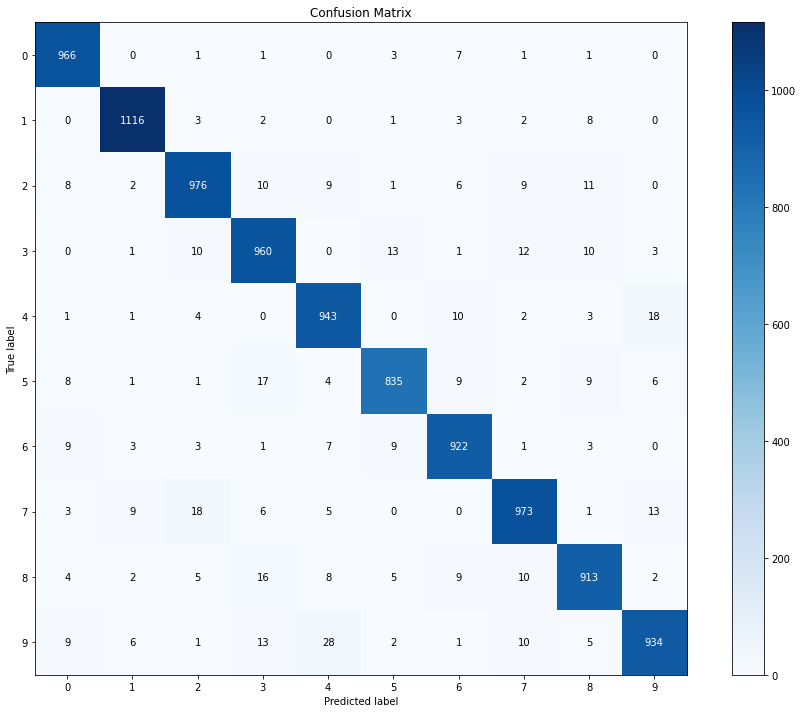

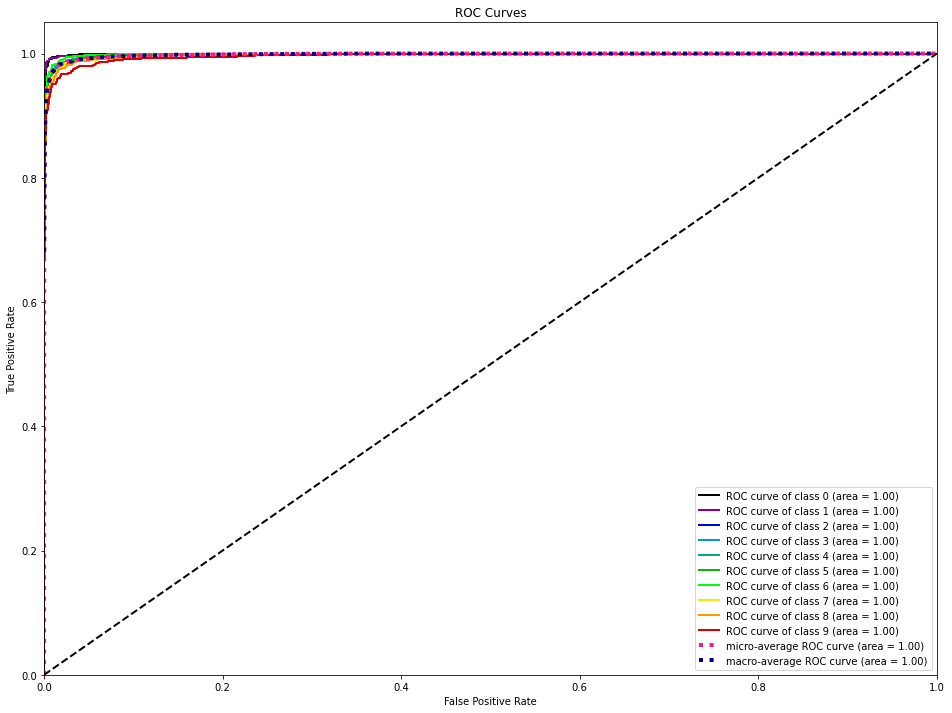

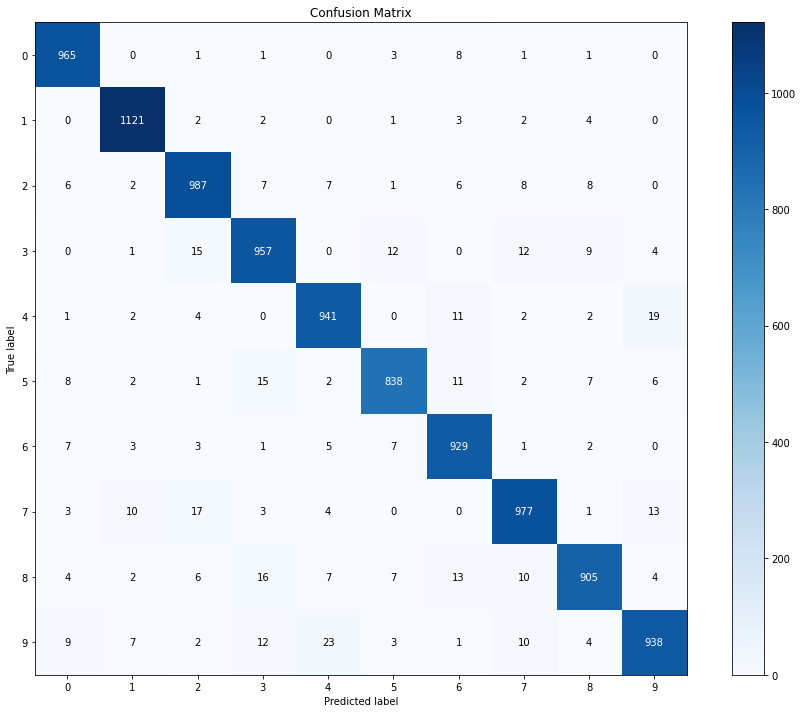

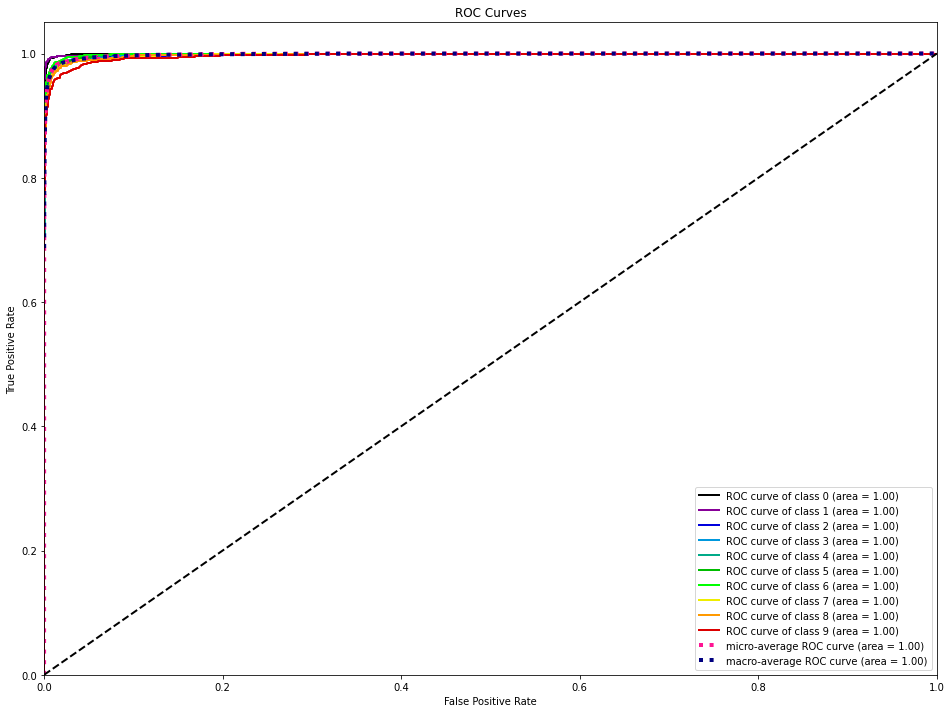

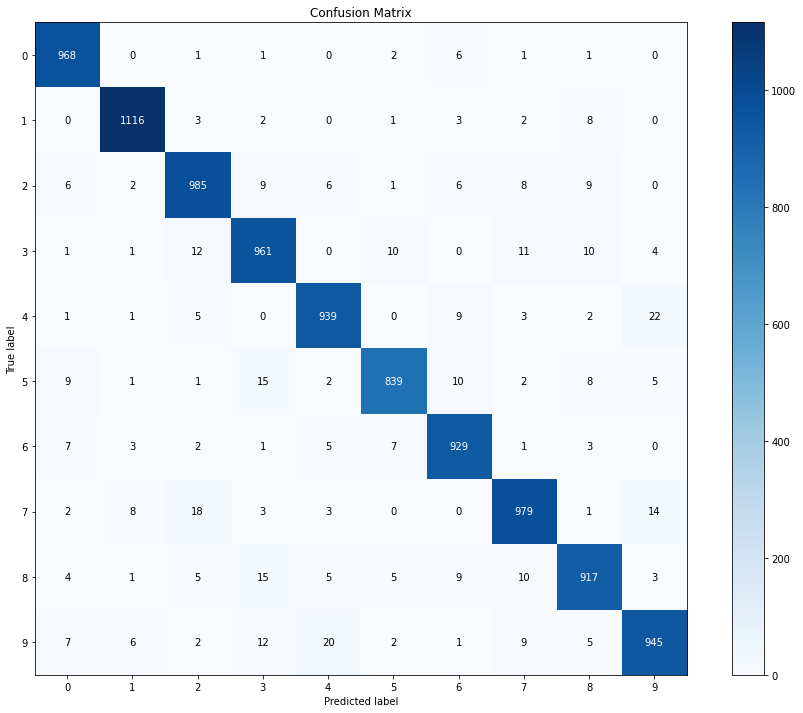

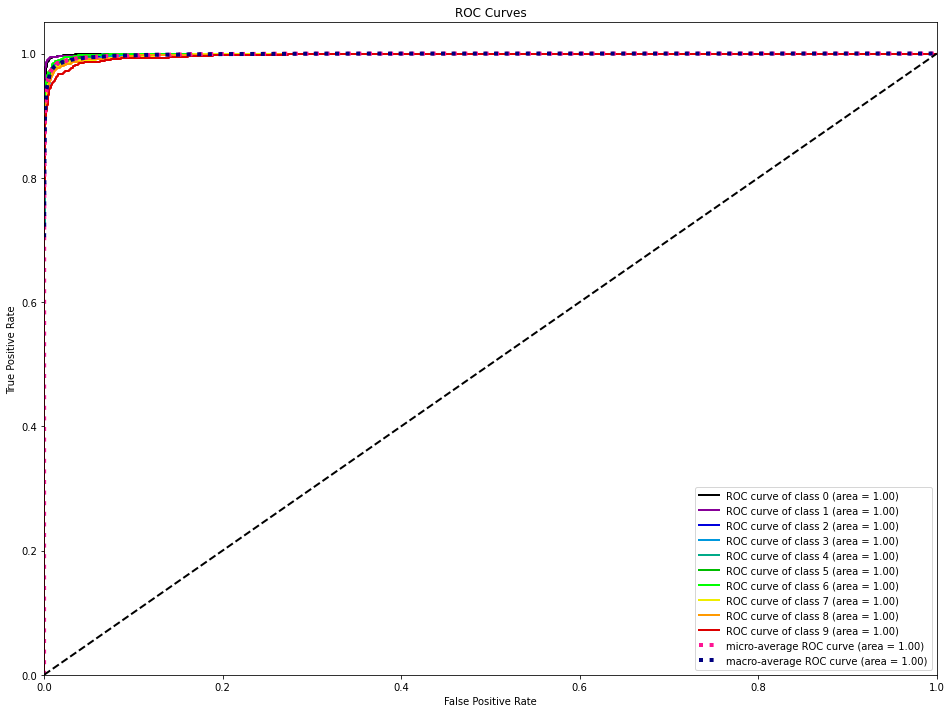

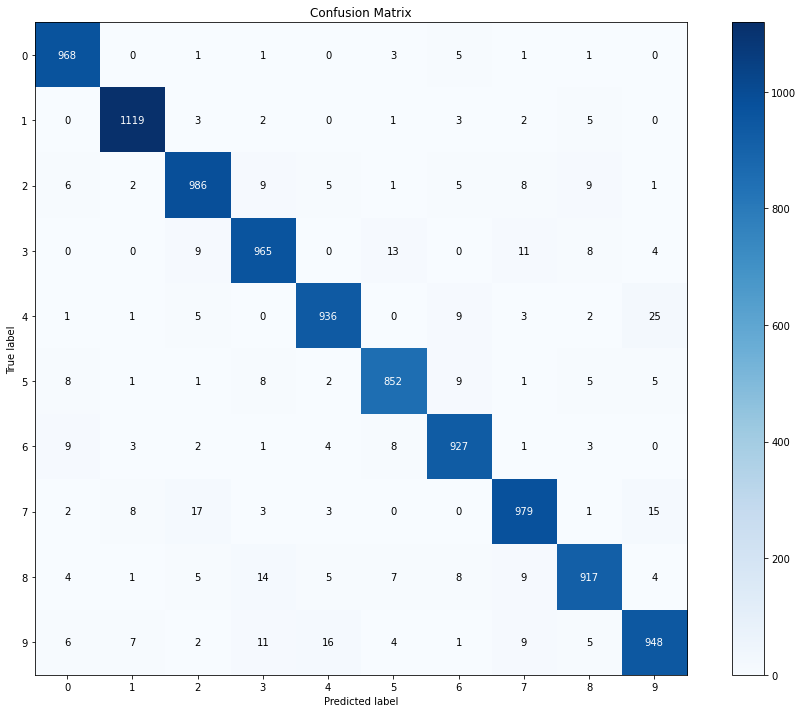

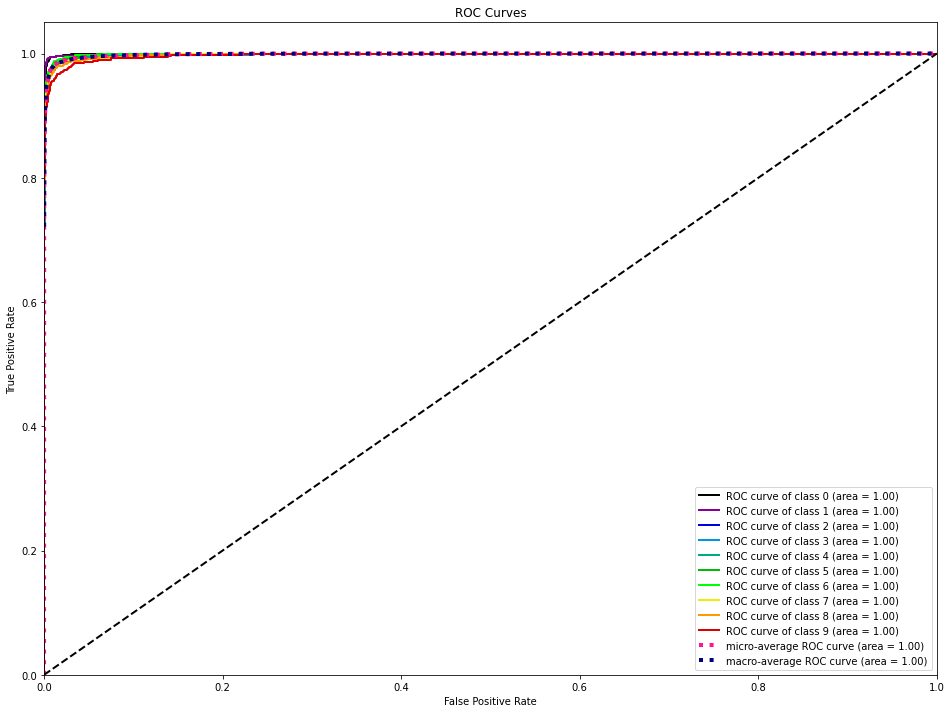

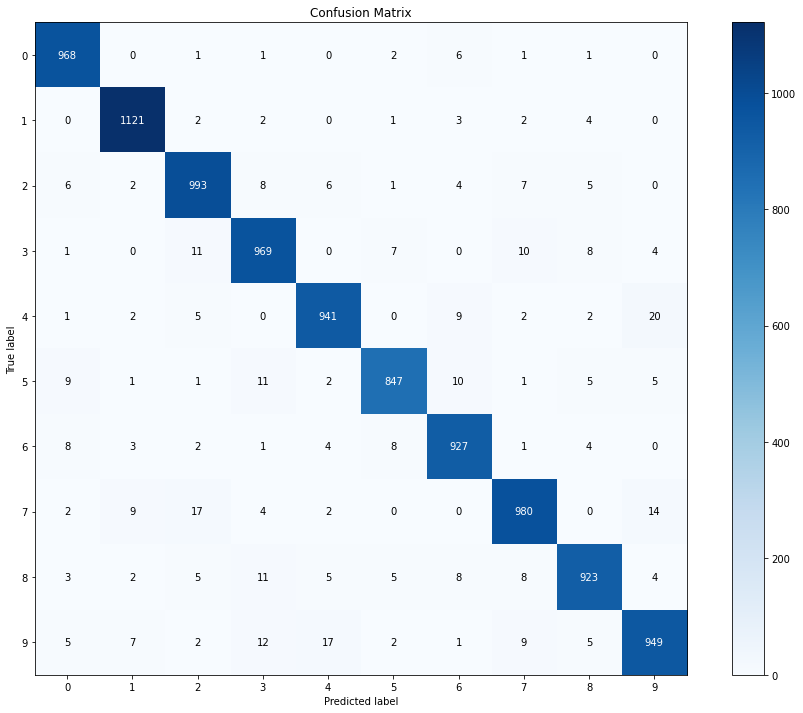

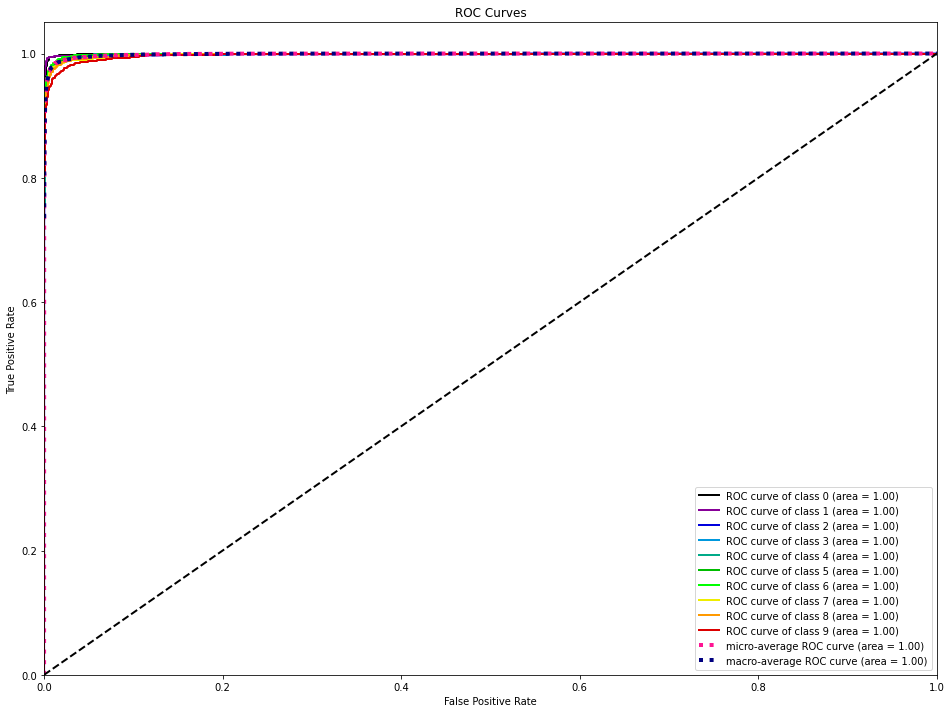

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=[performance_viz_cbk])

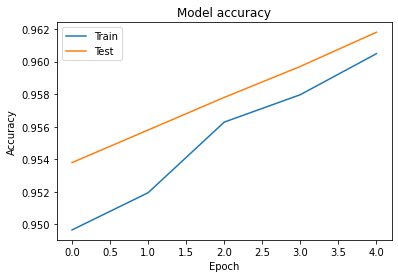

In [ ]:
plt.plot(history.history['acc'])#accuracy
plt.plot(history.history['val_acc']) #val_accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
ls -alrt ./perorfmance_charts/

total 584
drwxr-xr-x 1 root root  4096 Jun 23 05:25 ../
-rw-r--r-- 1 root root 37523 Jun 23 05:34 confusion_matrix_epoch_0.png
-rw-r--r-- 1 root root 79977 Jun 23 05:34 roc_curve_epoch_0.png
-rw-r--r-- 1 root root 37101 Jun 23 05:34 confusion_matrix_epoch_1.png
-rw-r--r-- 1 root root 79142 Jun 23 05:34 roc_curve_epoch_1.png
-rw-r--r-- 1 root root 36265 Jun 23 05:35 confusion_matrix_epoch_2.png
-rw-r--r-- 1 root root 77469 Jun 23 05:35 roc_curve_epoch_2.png
-rw-r--r-- 1 root root 36328 Jun 23 05:35 confusion_matrix_epoch_3.png
-rw-r--r-- 1 root root 76349 Jun 23 05:35 roc_curve_epoch_3.png
-rw-r--r-- 1 root root 35072 Jun 23 05:35 confusion_matrix_epoch_4.png
drwxr-xr-x 2 root root  4096 Jun 23 05:35 ./
-rw-r--r-- 1 root root 74139 Jun 23 05:35 roc_curve_epoch_4.png
